In [1]:
import os
os.chdir('/workspace/app')
import numpy as np
import cv2

In [2]:
from src.image_utils import read_tiff_from_file

label = read_tiff_from_file('/workspace/app/data/raw_data/STARCOP_train_easy/ang20190927t153023_r7101_c126_w151_h151/label_rgba.tif')
label_b = read_tiff_from_file('/workspace/app/data/raw_data/STARCOP_train_easy/ang20190927t153023_r7101_c126_w151_h151/labelbinary.tif')
mag1c = read_tiff_from_file('/workspace/app/data/raw_data/STARCOP_train_easy/ang20190927t153023_r7101_c126_w151_h151/mag1c.tif')

2025-07-11 18:06:10.844000: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 18:06:10.850154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752257170.856938   15599 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752257170.858962   15599 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752257170.864470   15599 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
label = label.any(axis=-1)

In [4]:
def extract_bounding_boxes(
    mask: np.ndarray, num_boxes: int = None, force_square: bool = False, padding: int = 10, kernel_size: int = 10
) -> list:
    """
    Extract bounding boxes from a binary mask.

    Parameters:
        mask (np.ndarray): Binary mask of shape (H, W)
        num_boxes (int, optional): Limit the number of boxes returned. If None, return all.
        force_square (bool): If True, force square bounding boxes.
        padding (int): Padding around boxes (in pixels) before normalization, default is 10.
        kernel_size (int): Size of the kernel for morphological dilation, default is 10.

    Returns:
        boxes: List of (objectness, x_center, y_center, width, height), all normalized to [0, 1].
    """
    H, W = mask.shape
    boxes = []
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    merged_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1).astype(np.uint8)

    num_components, _, stats, centroids = cv2.connectedComponentsWithStats(merged_mask, connectivity=8)

    for i in range(1, num_components):  # skip background
        x, y, w, h, area = stats[i]
        if area == 0:
            continue

        if force_square:
            side = max(w, h)
            cx, cy = centroids[i]
            x_min = int(cx - side / 2)
            y_min = int(cy - side / 2)
            x_max = x_min + side
            y_max = y_min + side
        else:
            x_min, y_min = x, y
            x_max, y_max = x + w, y + h

        # Apply padding
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(W, x_max + padding)
        y_max = min(H, y_max + padding)

        # Normalize
        box_w = x_max - x_min
        box_h = y_max - y_min
        x_center = (x_min + x_max) / 2 / W
        y_center = (y_min + y_max) / 2 / H
        width = box_w / W
        height = box_h / H

        boxes.append((1.0, x_center, y_center, width, height))

    if num_boxes is not None:
        if len(boxes) > num_boxes:
            boxes = boxes[:num_boxes]
        elif len(boxes) < num_boxes:
            boxes.extend([(0.0, 0.0, 0.0, 0.0, 0.0)] * (num_boxes - len(boxes)))

    return boxes

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_mask_with_bboxes(mask, boxes, alpha=0.5, box_color='red', figsize=(8, 8)):
    """
    Display a binary or grayscale mask with overlaid bounding boxes.

    Parameters:
        mask (np.ndarray): 2D binary or grayscale mask of shape (H, W).
        boxes (List[Tuple]): List of (class_id, x_center, y_center, width, height), normalized to [0, 1].
        alpha (float): Transparency of the mask overlay.
        box_color (str): Color of the bounding boxes.
        figsize (tuple): Size of the matplotlib figure.
    """
    H, W = mask.shape

    fig, ax = plt.subplots(figsize=figsize)
    
    # Show the mask as grayscale with alpha
    ax.imshow(mask, cmap='gray', interpolation='nearest', alpha=alpha)

    # Overlay bounding boxes
    for class_id, x_c, y_c, w, h in boxes:
        # Convert normalized to pixel coordinates
        box_w = w * W
        box_h = h * H
        x_min = x_c * W - box_w / 2
        y_min = y_c * H - box_h / 2

        rect = patches.Rectangle(
            (x_min, y_min), box_w, box_h,
            linewidth=2, edgecolor=box_color, facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title("Label mask with YOLO bounding boxes")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
extract_bounding_boxes(label)

[(1.0,
  np.float64(0.421875),
  np.float64(0.5),
  np.float64(0.5078125),
  np.float64(0.3515625))]

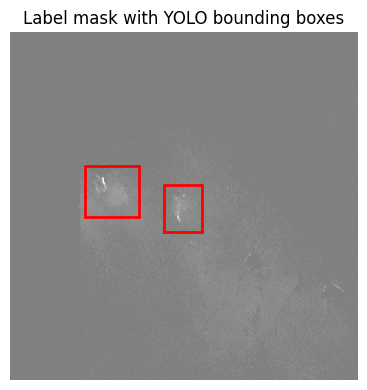

In [8]:
show_mask_with_bboxes(mag1c, extract_bounding_boxes(label_b, padding=10), alpha=0.5, box_color='red', figsize=(4, 4))